**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1ztOut8G2BQAOfQNrXmBhIyGhgaYyuYk4?usp=sharing)
2. [Практический ноутбук 1](https://colab.research.google.com/drive/1wR8vbQ1LSJy1ZER3wIgXENUT0K-Q15Qh?usp=sharing)
2. Практический ноутбук 2

# Сверточные нейронные сети. Распознавание марок машин


Основное содержание данного ноутбука - демонстрация способа генерации изображений для увеличения объема обучающей набора данных.

Хорошая по объему и качеству база данных - вечная проблема AI-разработчика. Недостаточное количество обучающих данных может привести как к низкой точности работы нейронной сети, так и к переобучению.

При работе с изображениями выходом из подобной ситуации служит аугментация. Что это такое? Это способ генерации новых изображений, похожих на образцы, с изменением позиции, масштаба, яркости и некоторых дополнительных параметров. Фактически, изображения-образцы и аугментированные изображения - это абсолютно одно и то же с точки зрения смысла информации. Но цель аугментации не сгенерировать совсем новые изображения; аугментация помогает нейронной сети просмотреть больше вариантов одних и тех изображений и лучше выделить общие признаки, когда база данных слишком мала.

Датасет, на котором проводится дальнейшая аугментация и обучение - база фотографий машин. Всего **3** класса: ***Феррари, Мерседес, Рено***. Объём базы - **3427** изображений.

Произведём импорт необходимых библиотек и приступим к работе.

## Загрузка библиотек


In [1]:
# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Рисование графиков в ячейках Colab
%matplotlib inline

E0000 00:00:1741602241.848667  141478 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741602241.852538  141478 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Задание гиперпараметров модели


Для начала необходимо правильно сгруппировать и организовать значения параметров, по которым будут производиться аугментация и обучение модели. Сперва зададим гиперпараметры для сети, которые включают директории для данных, значения для разделения выборок и входного размера изображений. Затем - значения для конфигурации самой аугментации, включающие пределы изменений положения авто, масштаба и яркости изображения. Далее, по доброй традиции, сохранённые значения будет легко передать в параметры соответствующих функций.

In [2]:
# Задание гиперпараметров

TRAIN_PATH          = 'cars'       # Папка для обучающего набора данных
TEST_PATH           = 'cars_test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.1                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 128                   # Ширина изображения для нейросети
IMG_HEIGHT          = 64                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 60                    # Число эпох обучения
BATCH_SIZE          = 24                    # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

I0000 00:00:1741602247.484470  141478 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Загрузка датасета и подготовка данных

Хорошим правилом при работе с любой задачей является наличие нескольких запусков обучения. Как минимум, этот подход позволяет сравнить разные точности обучения, поработать с гиперпараметрами и архитектурой сети, а для хорошего результата он необходим. Перед распаковкой изображений уничтожим все данные предыдущих пусков, что сделаем при помощи команд оболочки Linux:

In [ ]:
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)

'middle_fmr.zip'

In [3]:
# Очистка данных от прошлого запуска (если есть)
!rm -rf {TRAIN_PATH} {TEST_PATH}

# Разархивация датасета в директорию данных
!unzip -qo "middle_fmr.zip" -d {TRAIN_PATH}

Определим список классов и их число:

In [4]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


Исходная база ещё не разделена на выборки. Вполне естественно, что для тестовых данных аугментация не требуется - они не участвуют в обучении модели. По этой причине данные для теста необходимо сразу отделить от обучающих и проверочных. Таким образом, часть изображений просто выделяется для тестирования модели и размещается в отдельной папке. Для разделения данных требуется не только создать папку и указать путь к ней; также нужно определить количество изображений в каждом из трёх классов, выделить некоторую их долю (заданную в гиперпараметрах) в каждом классе, и уже потом переместить файлы по указанному пути в папку. Разумеется, правильнее решить эту задачу при помощи цикла:

In [5]:
int(1088 * 0.1)

108

In [6]:
photo_1 = 'cars/Ferrari/car_Ferrari__0.png'
photo_1 = 'cars_test/Ferrari/car_Ferrari__0.png'

In [7]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

try:
  os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
except:
  pass

train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    try:
      os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    except:
      pass

    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 1088 машин, для теста выделено файлов: 108
Размер класса Mercedes: 1161 машин, для теста выделено файлов: 116
Размер класса Renault: 1178 машин, для теста выделено файлов: 117
Общий размер базы: 3427, выделено для обучения: 3086, для теста: 341


## Аугментация и формирование выборок

Главная задача по увеличению базы изображений для обучения решается путем использования встроенного механизма Keras, он называется **ImageDataGenerator**. В параметрах генератора задаются все необходимые разрешения и пределы изменений исходного изображения - сдвиг, вращение, увеличение или отдаление, яркость и другие. Там же можно произвести нормализацию данных, что очень удобно (за это отвечает параметр **rescale**). Все параметры генератора называются соответсвующим их действию образом; удобства ради значения для них были заданы одноименно в верхнем регистре (ячейка гиперпараметров в начале ноутбука). Теперь остаётся только создать отдельный генератор для обучения, и отдельный для теста модели.

### Генераторы изображений и выборок

In [8]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

Изображения для теста должны остаться в исходном виде. С ними будет проведена только нормализация.

Существует удобный метод генератора - `.flow_from_directory()`, который помогает извлечь из папок изображения для генерации, посчитать классы и автоматически вычислить метки классов для изображений. Было создано два отдельных генератора, поэтому тестовые изображения при прохождении через генератор не аугментируются, а только нормализуются. При этом обучающая и проверочная выборки будет иметь кол-во элементов в одном подаваемом объекте - BATCH_SIZE(24), а тестовая выборка включит в себя все тестовые изображения (batch_size равен test_count(341)), когда всего тестовых изображение тоже test_count((341))).

In [9]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 2469 images belonging to 3 classes.
Found 617 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [10]:
len(train_generator[0]) == 24

False

In [11]:
train_generator[0]
# (список пар изображений-меток)

(array([[[[0.30980393, 0.31764707, 0.2392157 ],
          [0.30980393, 0.31764707, 0.2392157 ],
          [0.30980393, 0.31764707, 0.2392157 ],
          ...,
          [0.14901961, 0.16470589, 0.20392159],
          [0.16862746, 0.17254902, 0.21960786],
          [0.15294118, 0.16862746, 0.20784315]],
 
         [[0.30980393, 0.31764707, 0.2392157 ],
          [0.30980393, 0.31764707, 0.2392157 ],
          [0.30980393, 0.31764707, 0.2392157 ],
          ...,
          [0.15294118, 0.16470589, 0.20784315],
          [0.16862746, 0.17254902, 0.21960786],
          [0.15294118, 0.16862746, 0.20784315]],
 
         [[0.30980393, 0.31764707, 0.2392157 ],
          [0.30980393, 0.31764707, 0.2392157 ],
          [0.30980393, 0.31764707, 0.2392157 ],
          ...,
          [0.15294118, 0.16862746, 0.20784315],
          [0.16862746, 0.17254902, 0.21960786],
          [0.14901961, 0.16862746, 0.20784315]],
 
         ...,
 
         [[0.43529415, 0.427451  , 0.43921572],
          [0.43137

In [12]:
train_generator[0][0]
# (изображение, метка)

array([[[[0.11764707, 0.12156864, 0.15686275],
         [0.12941177, 0.12941177, 0.15686275],
         [0.14117648, 0.14509805, 0.16470589],
         ...,
         [0.2392157 , 0.24313727, 0.18431373],
         [0.2392157 , 0.24313727, 0.18431373],
         [0.2392157 , 0.24313727, 0.18431373]],

        [[0.1137255 , 0.12156864, 0.15686275],
         [0.12941177, 0.12941177, 0.15686275],
         [0.13725491, 0.14117648, 0.16470589],
         ...,
         [0.2392157 , 0.24313727, 0.18431373],
         [0.2392157 , 0.24313727, 0.18431373],
         [0.2392157 , 0.24313727, 0.18431373]],

        [[0.10980393, 0.11764707, 0.15294118],
         [0.1254902 , 0.12941177, 0.16078432],
         [0.13725491, 0.13725491, 0.16078432],
         ...,
         [0.2392157 , 0.24313727, 0.18431373],
         [0.2392157 , 0.24313727, 0.18431373],
         [0.2392157 , 0.24313727, 0.18431373]],

        ...,

        [[0.14901961, 0.1137255 , 0.08235294],
         [0.18823531, 0.16470589, 0.10196079]

In [13]:
train_generator[0][0][0]
# изображение

array([[[0.5294118 , 0.50980395, 0.33333334],
        [0.5254902 , 0.50980395, 0.32941177],
        [0.38823533, 0.4039216 , 0.28627452],
        ...,
        [0.3019608 , 0.29803923, 0.2627451 ],
        [0.19607845, 0.19215688, 0.17254902],
        [0.07843138, 0.08627451, 0.07450981]],

       [[0.5764706 , 0.5647059 , 0.54901963],
        [0.56078434, 0.56078434, 0.5372549 ],
        [0.45882356, 0.45882356, 0.45098042],
        ...,
        [0.29803923, 0.29411766, 0.25882354],
        [0.19215688, 0.18823531, 0.16862746],
        [0.07843138, 0.08627451, 0.07450981]],

       [[0.5372549 , 0.5411765 , 0.5058824 ],
        [0.4156863 , 0.427451  , 0.3647059 ],
        [0.41176474, 0.41176474, 0.34901962],
        ...,
        [0.29411766, 0.2901961 , 0.25490198],
        [0.18823531, 0.18039216, 0.16470589],
        [0.07843138, 0.08627451, 0.07450981]],

       ...,

       [[0.44705886, 0.4431373 , 0.47058827],
        [0.45098042, 0.44705886, 0.47450984],
        [0.4666667 , 0

In [14]:
train_generator[0][0][1]
# метка

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.2901961 , 0.49803925, 0.7254902 ],
        [0.2901961 , 0.49803925, 0.7254902 ],
        [0.2901961 , 0.49803925, 0.7254902 ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.2901961 , 0.49803925, 0.7254902 ],
        [0.2901961 , 0.49803925, 0.7254902 ],
        [0.2901961 , 0.49803925, 0.7254902 ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.2901961 , 0.49803925, 0.7254902 ],
        [0.2901961 , 0.49803925, 0.7254902 ],
        [0.2901961 , 0.49803925, 0.7254902 ]],

       ...,

       [[0.14509805, 0.19215688, 0.2392157 ],
        [0.14509805, 0.19215688, 0.2392157 ],
        [0.1764706 , 0

In [ ]:
#curr
#  batch
#    x_train
#    y_train
#next
#  batch
#    x_train
#    y_train

In [ ]:
#  batch
#    x_train
#    y_train

In [15]:
class Some:
  def __init__(self, array):
    self.array = array
  def run(self):
    return '123'

  def __len__(self):
    return len(self.array)


In [16]:
sss = Some([1,2,3,4,5])

In [17]:
sss.run()

'123'

In [18]:
len(sss.array)

5

In [19]:
len(sss)

5

In [20]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (24, 64, 128, 3), (24, 3), батчей: 103
Формы данных   проверочной выборки: (24, 64, 128, 3), (24, 3), батчей: 26
Формы данных      тестовой выборки: (341, 64, 128, 3), (341, 3), батчей: 1

Метки классов тренировочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов   проверочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов      тестовой выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}


In [21]:
len(train_generator)

103

In [22]:
len(train_generator[0])

2

In [23]:
x_train, y_train = train_generator[0]

In [24]:
len(x_train), len(y_train)

(24, 24)

In [25]:
y_train[0].shape

(3,)

In [26]:
x_train[0].shape

(64, 128, 3)

In [ ]:
#batches
  #x_train
    #batch
      #изображение
  #y_train
    #batch
      #метка

### Проверка работы генераторов выборок

Посмотрите, как работают генераторы выборок. Для начала позапускайте следующую ячейку несколько раз. Аугментация работает "на лету".

Индексы для примера выбраны такие: `[1][0][2]`, что означает:
 - **1**: номер батча в выборке. Сам батч - это кортеж (**x_train, y_train**) с примерами и метками классов;
 - **0**: первый элемент в кортеже, то есть сами изображения. Под индексом **1** будут метки классов в формате **one hot encoding** для изображений;
 - **2**: номер картинки в батче.

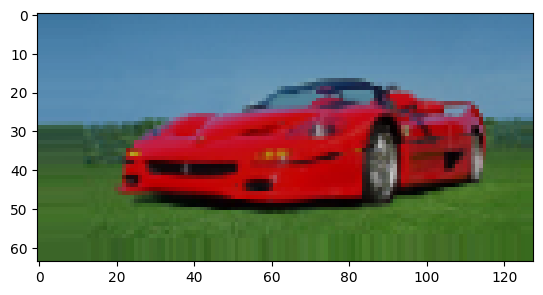

In [35]:
# Проверка одного изображения из выборки
plt.imshow(train_generator[1][0][2])
plt.show()

Сама же картинка представлена в виде трехмерного массива нормализованных пикселей (от **0** до **1**):

In [36]:
train_generator[1][0][2]

array([[[0.2392157 , 0.44705886, 0.59607846],
        [0.24313727, 0.44705886, 0.6       ],
        [0.2509804 , 0.45098042, 0.6       ],
        ...,
        [0.27058825, 0.46274513, 0.6117647 ],
        [0.27058825, 0.46274513, 0.6117647 ],
        [0.27058825, 0.46274513, 0.6117647 ]],

       [[0.2509804 , 0.454902  , 0.6039216 ],
        [0.2509804 , 0.45098042, 0.6       ],
        [0.2509804 , 0.454902  , 0.6039216 ],
        ...,
        [0.27450982, 0.47058827, 0.62352943],
        [0.27450982, 0.47058827, 0.62352943],
        [0.27450982, 0.47058827, 0.627451  ]],

       [[0.25882354, 0.45882356, 0.6117647 ],
        [0.25882354, 0.45882356, 0.6117647 ],
        [0.25882354, 0.45882356, 0.6117647 ],
        ...,
        [0.28235295, 0.47450984, 0.627451  ],
        [0.28235295, 0.47450984, 0.627451  ],
        [0.28235295, 0.47450984, 0.627451  ]],

       ...,

       [[0.22352943, 0.38823533, 0.15294118],
        [0.21568629, 0.37647063, 0.12941177],
        [0.20784315, 0

Теперь создадим функцию для удобного просмотра сразу множества картинок из заданного батча. Для отрисовки нескольких изображений используем функцию `.subplots()` библиотеки **matplolib.pyplot**.



In [ ]:
0,1,2,3,4      --- 0, 1, 2, 3, 4
5,6,7,8,9      --- 0, 1, 2, 3, 4
10,11,12,13,14 --- 0, 1, 2, 3, 4
....

In [37]:
x_train, y_train = train_generator[0]

In [38]:
batch = train_generator[0]

In [39]:
batch[0][]

SyntaxError: invalid syntax (151988597.py, line 1)

In [40]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(20),  # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

Посмотрим на примеры картинок из генераторов. Можно запускать ячейки несколько раз - аугментация работает "на лету".

Примеры из обучающей выборки:

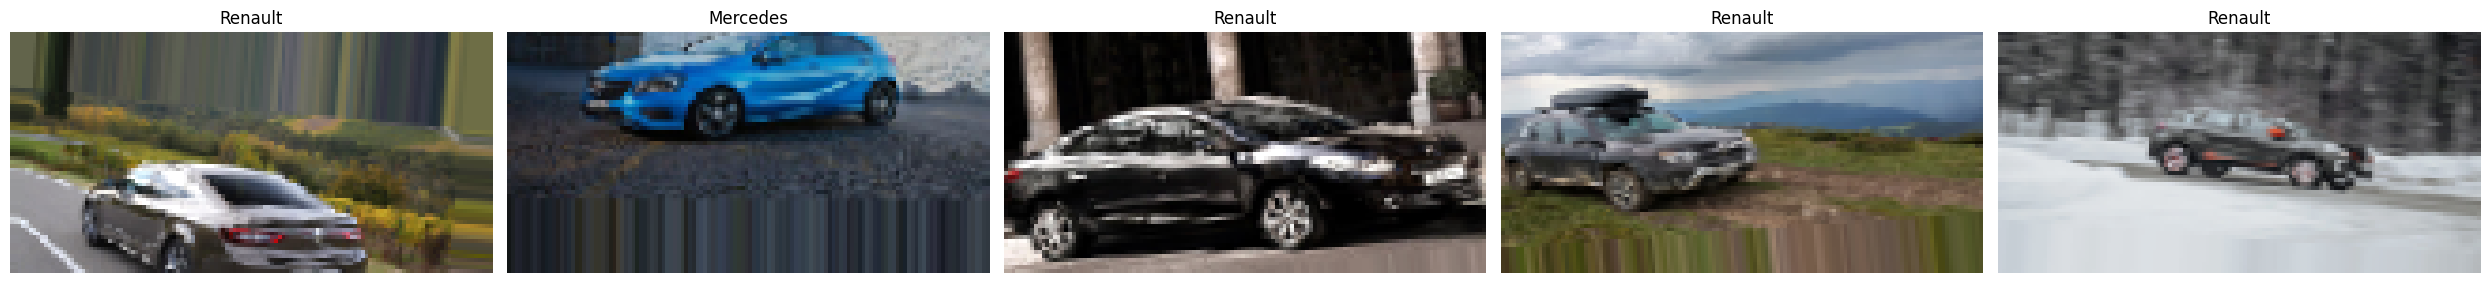

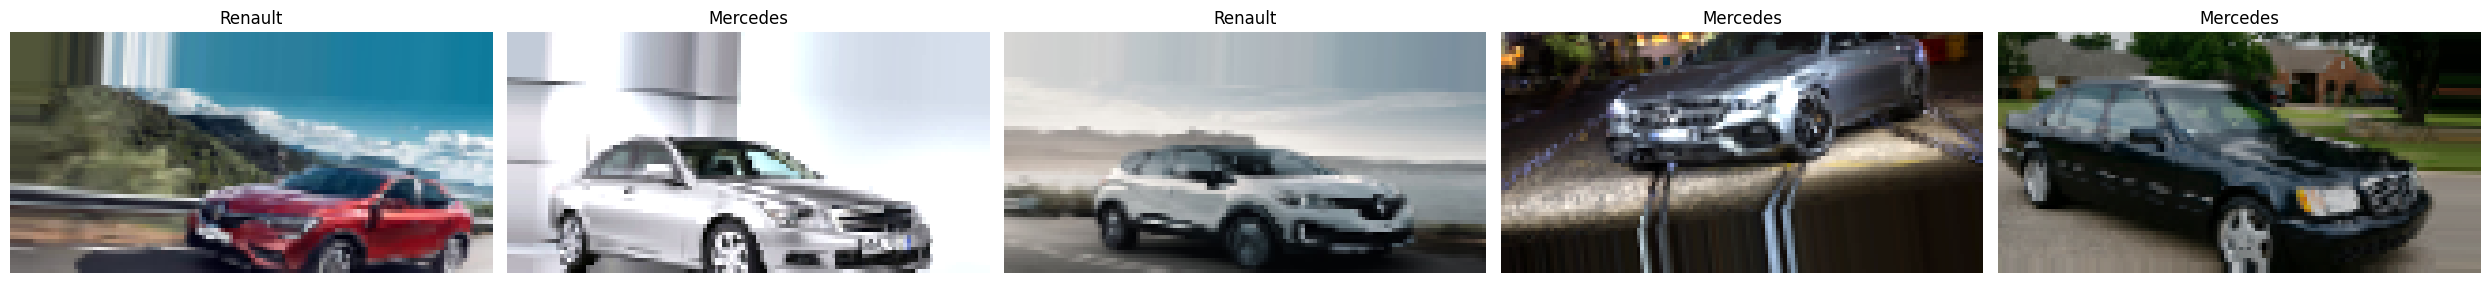

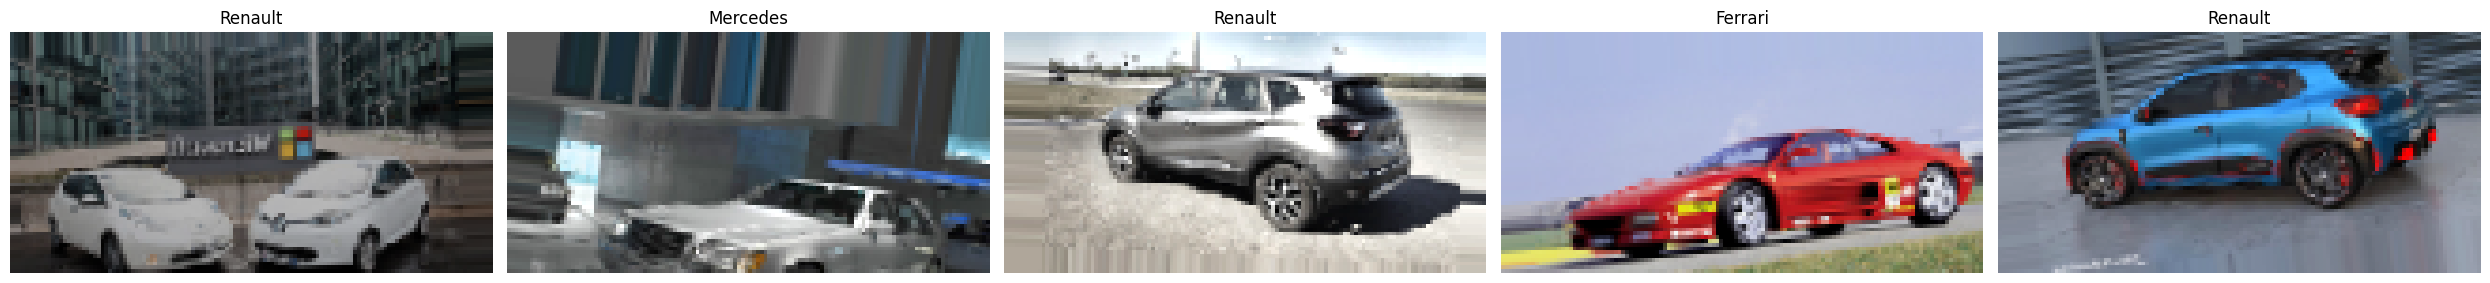

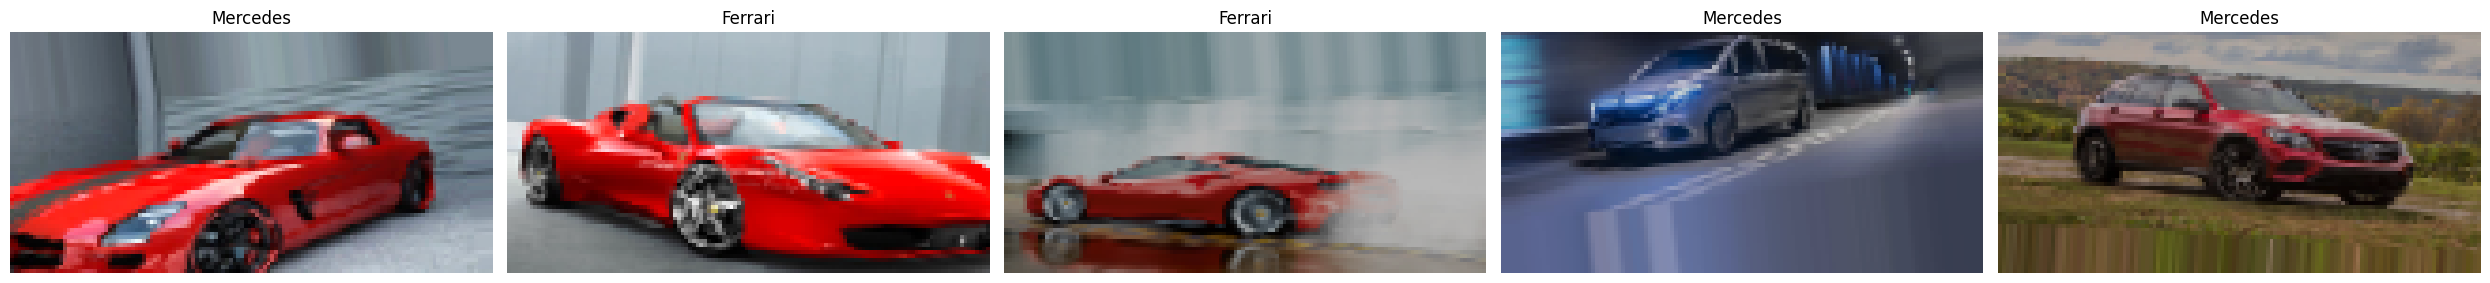

In [41]:
# Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0])

Примеры из проверочной выборки:

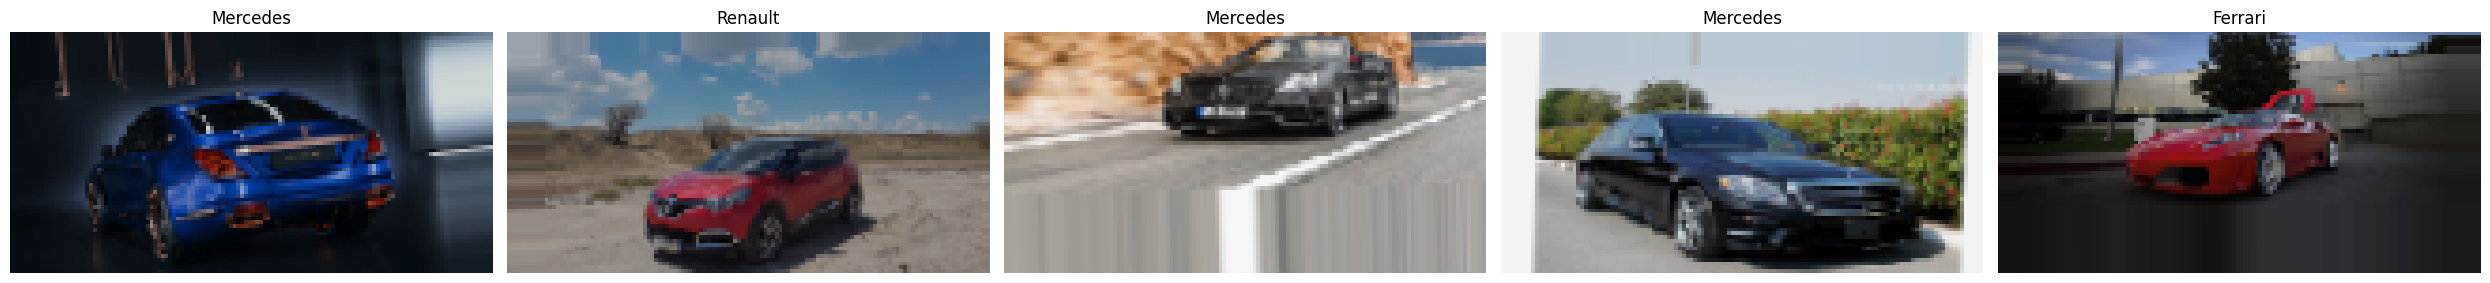

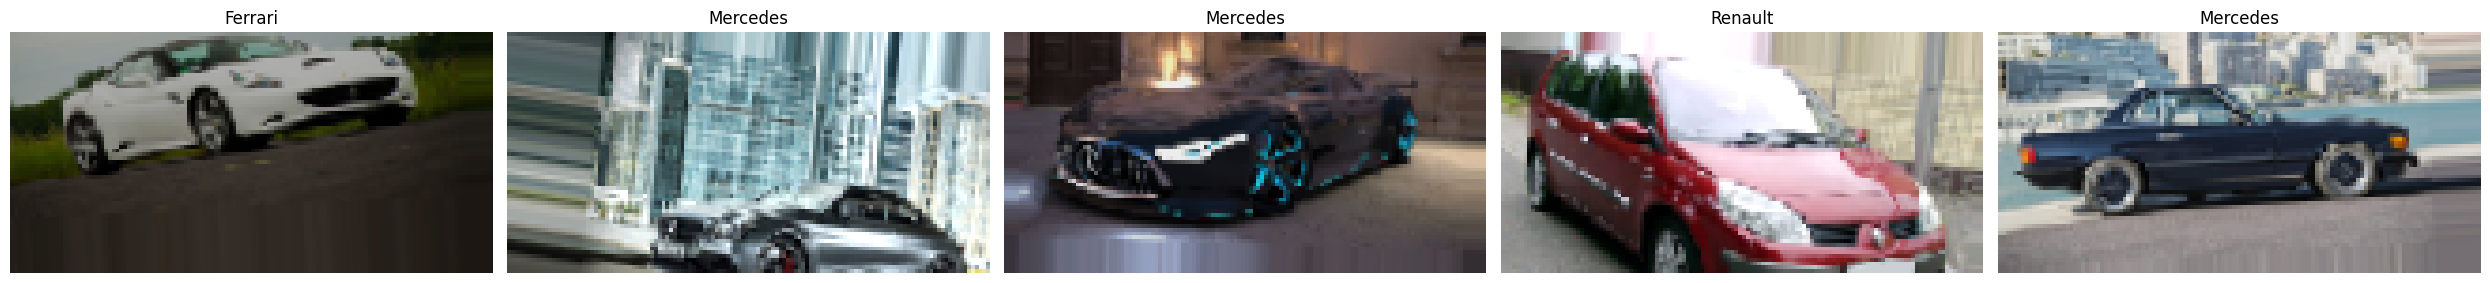

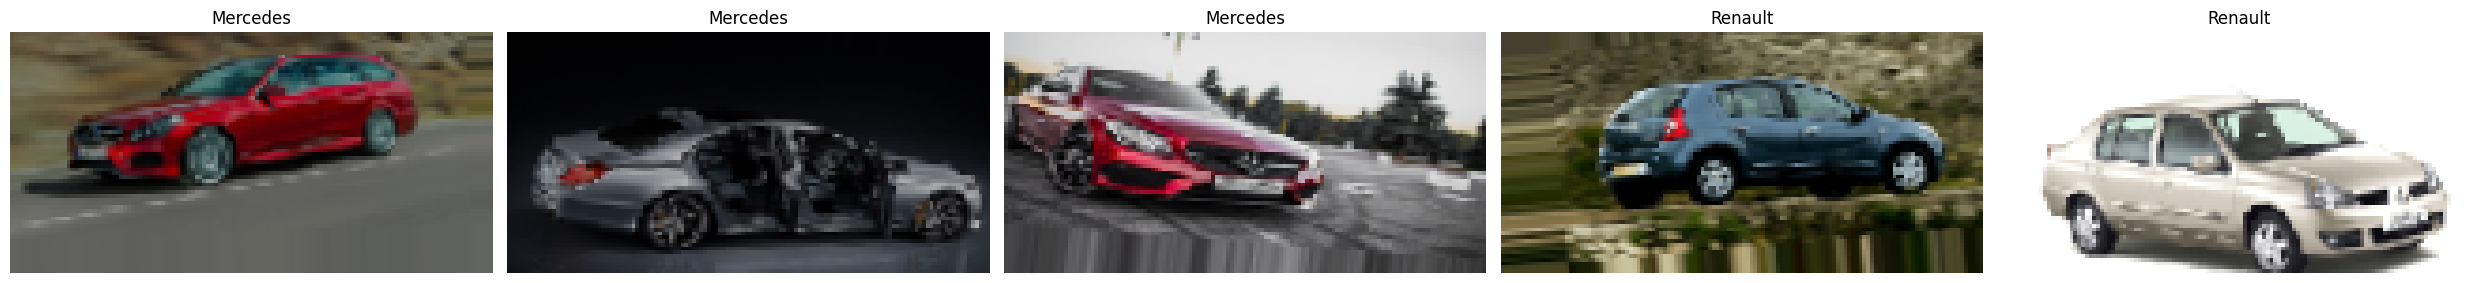

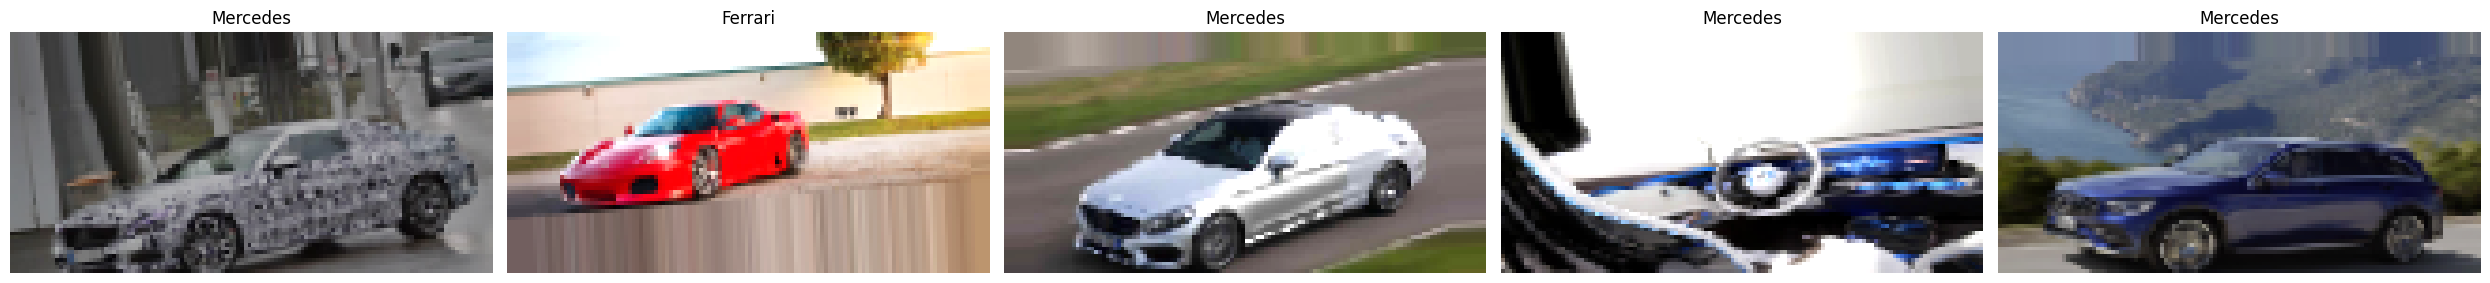

In [45]:
# Вывод примеров из 0-го батча validation_generator
show_batch(validation_generator[0])

Обратите внимание, что картинки тестового набора не аугментируются, а только приводятся к нужному размеру и нормализуются - содержимое батча не меняется при перезапусках ячейки:

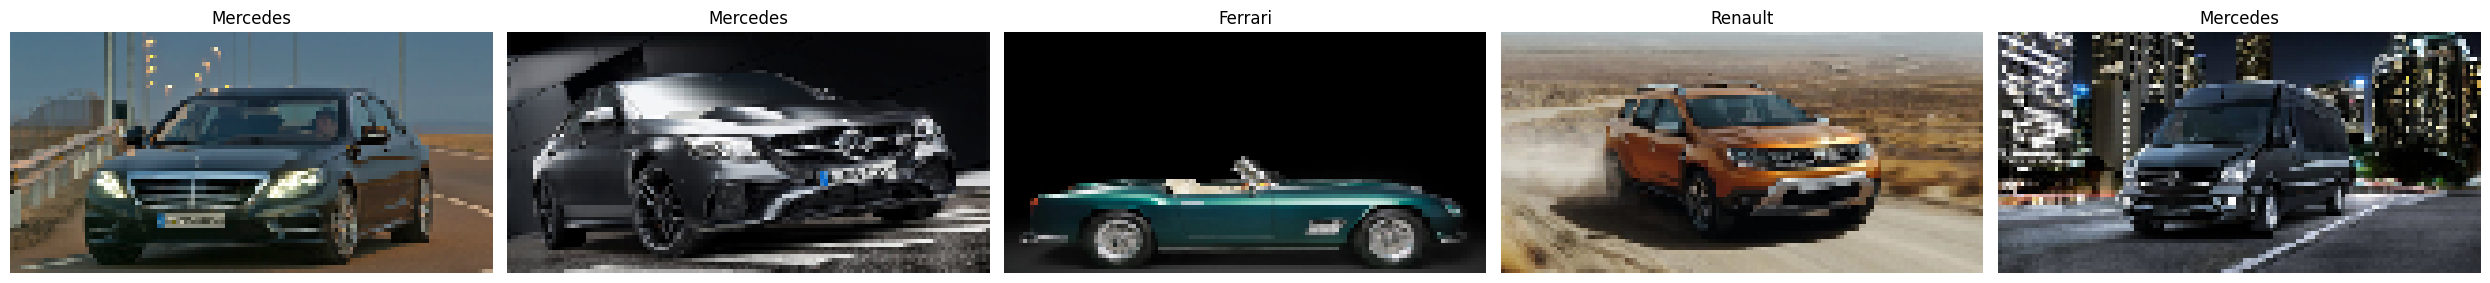

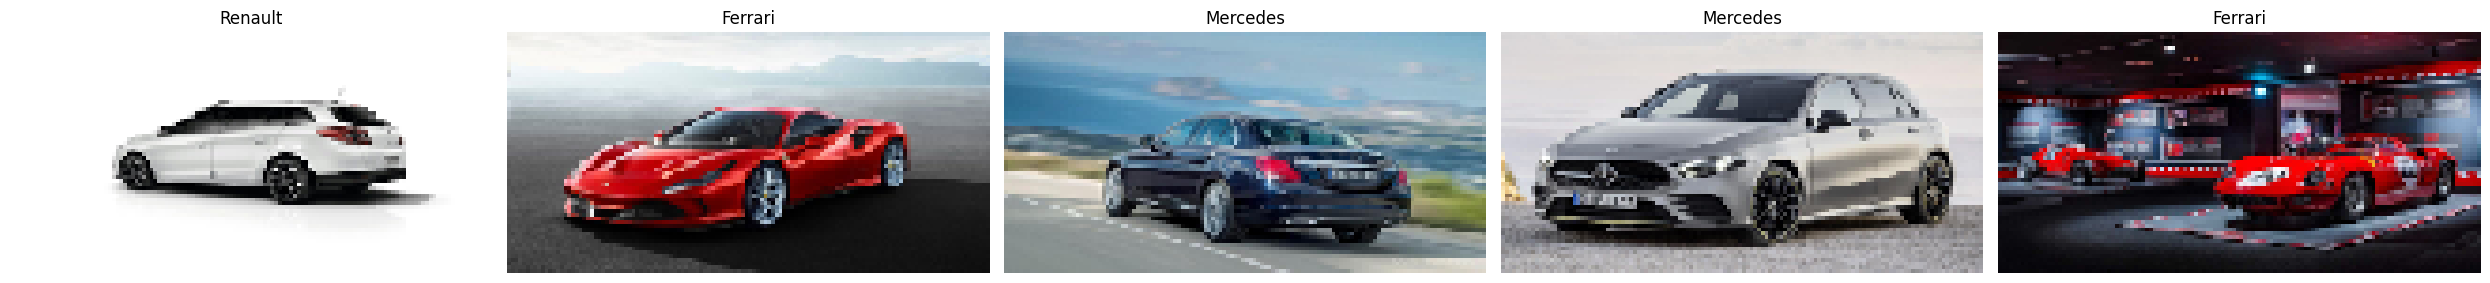

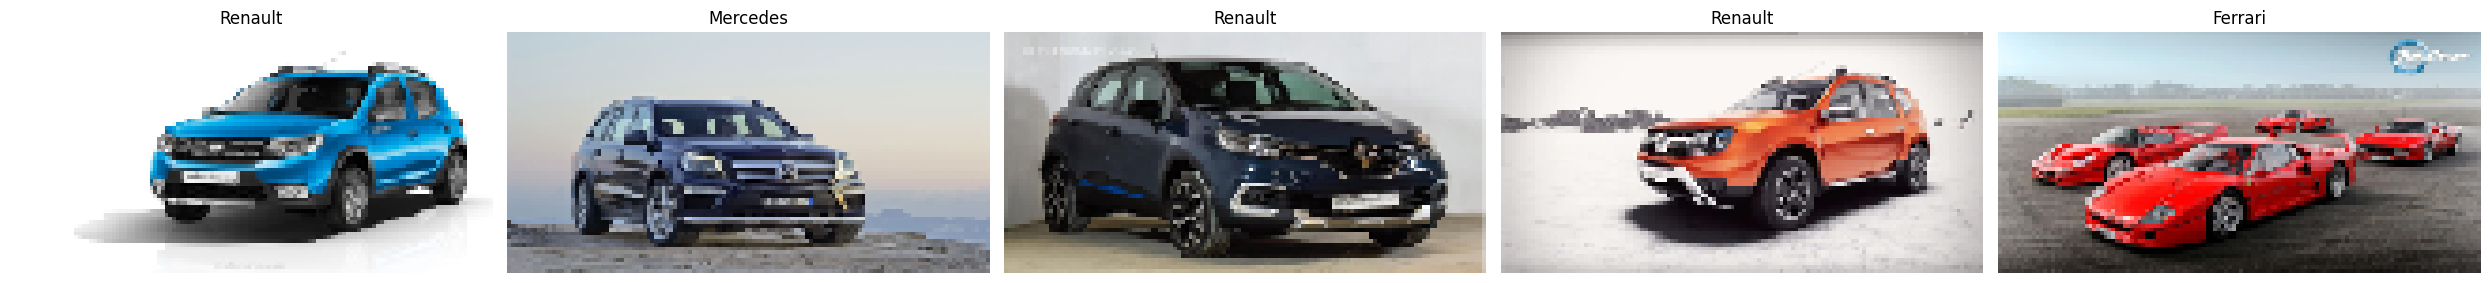

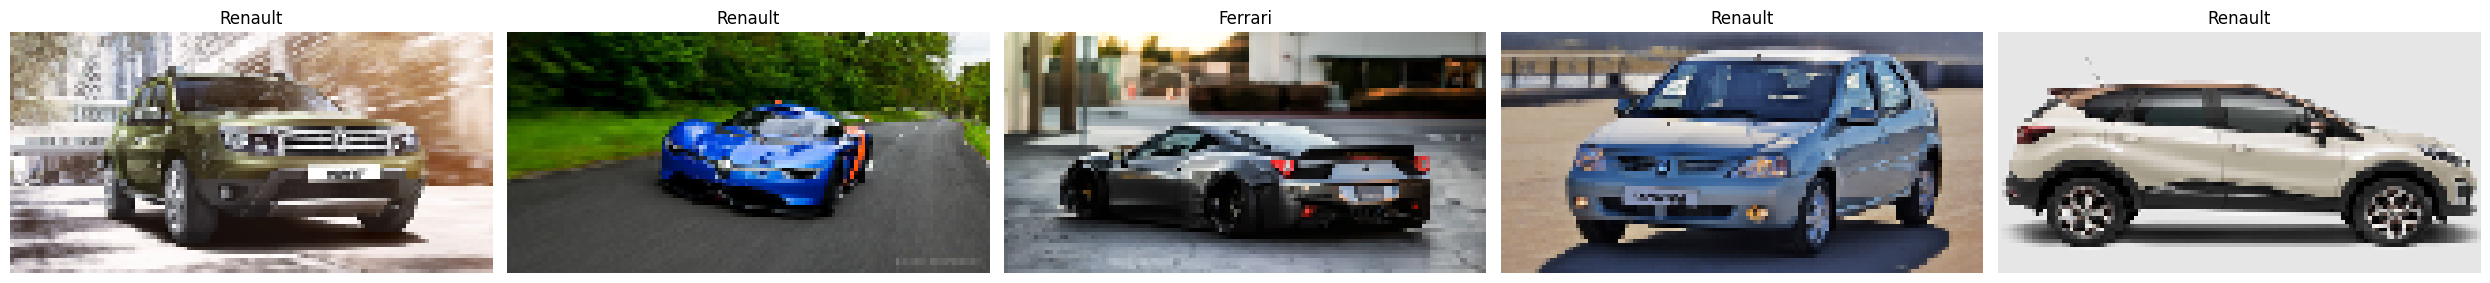

In [44]:
# Вывод примеров из 0-го (единственного) батча test_generator
show_batch(test_generator[0])

В самом деле, тест модели проводится на картинках из реального датасета, которые никогда модели не предъявлялись. Аугментировать их нет необходимости.

## Создание и обучение модели нейронной сети

После того, как вы убедились в правильной работе объекта **ImageDataGenerator** на примерах из конкретного батча, можно перейти к обучению модели. Для этого будет удобнее сразу создать необходимые функции, включающие компиляцию, обучение, построение графиков ошибки и точности, оценку предсказаний модели. Впоследствие функции можно использовать многократно, избегая повторов и внесения ошибок в код.

### Сервисные функции

In [46]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        # batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [48]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [47]:
# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1],
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

### Архитектура модели нейронной сети

Теперь создадим модель, обучим ее на генерируемых данных и оценим работу на тестовых:

/home/aledonio/.cache/pypoetry/virtualenvs/global-cKEoLTwX-py3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 128, 256)   │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 128, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 128, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 42, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 42, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 42, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 42, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 42, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 14, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 14, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 14, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 14, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 14, 1024)    │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │    16,779,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,865,539 (125.37 MB)

 Trainable params: 32,863,491 (125.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

/home/aledonio/.cache/pypoetry/virtualenvs/global-cKEoLTwX-py3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


I0000 00:00:1741604166.961997  141780 service.cc:148] XLA service 0x7fd7e4005d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741604166.963543  141780 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
I0000 00:00:1741604167.562053  141780 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1741604181.851370  141780 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


103/103 ━━━━━━━━━━━━━━━━━━━━ 52s 327ms/step - accuracy: 0.4662 - loss: 1.7952 - val_accuracy: 0.3177 - val_loss: 1.1137
Epoch 2/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.5266 - loss: 0.9682 - val_accuracy: 0.3387 - val_loss: 1.1042
Epoch 3/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.5541 - loss: 0.9056 - val_accuracy: 0.3339 - val_loss: 1.0895
Epoch 4/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 28s 267ms/step - accuracy: 0.5947 - loss: 0.8714 - val_accuracy: 0.3387 - val_loss: 1.1087
Epoch 5/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.6108 - loss: 0.8296 - val_accuracy: 0.5770 - val_loss: 0.9199
Epoch 6/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.6379 - loss: 0.8030 - val_accuracy: 0.5689 - val_loss: 0.9129
Epoch 7/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - accuracy: 0.6359 - loss: 0.7977 - val_accuracy: 0.5300 - val_loss: 1.0027
Epoch 8/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 27s 259ms/step - accuracy: 0.6522 - loss: 0.7676 - val

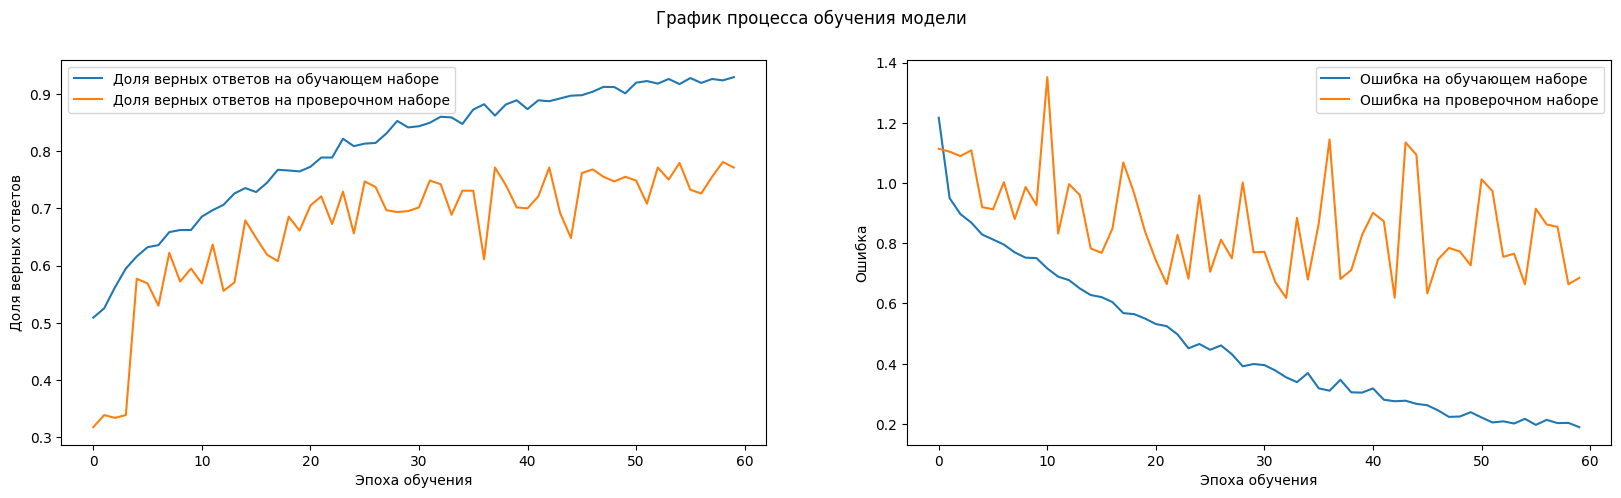

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 374ms/step


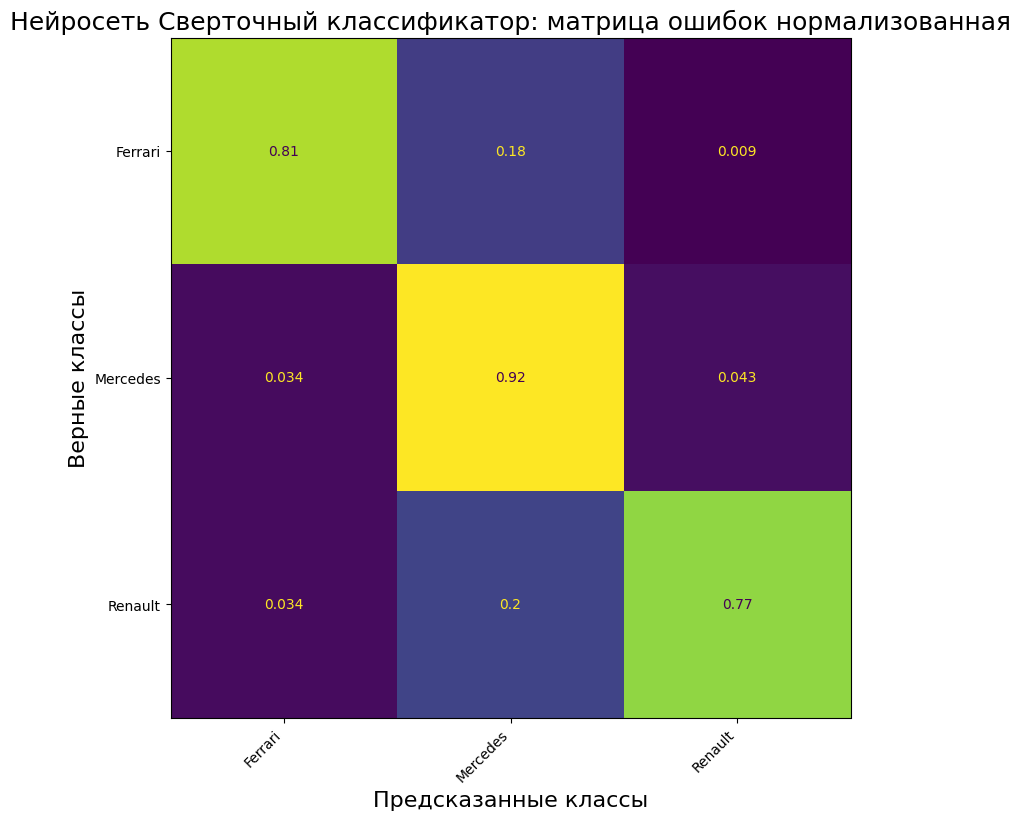

----------------------------------------------------------------------------------------------------
Нейросеть: Сверточный классификатор
Класс: Ferrari               82% сеть отнесла к классу Ferrari              - ВЕРНО :-)
Класс: Mercedes              92% сеть отнесла к классу Mercedes             - ВЕРНО :-)
Класс: Renault               77% сеть отнесла к классу Renault              - ВЕРНО :-)

Средняя точность распознавания:  84%


In [49]:
# Создание последовательной модели
model_conv = Sequential()

# Первый сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model_conv.add(BatchNormalization())

# Второй сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))

# Третий сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Dropout(0.2))

# Четвертый сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.2))

# Пятый сверточный слой
model_conv.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())

# Шестой сверточный слой
model_conv.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.2))

# Слой преобразования многомерных данных в одномерные
model_conv.add(Flatten())

# Промежуточный полносвязный слой
model_conv.add(Dense(2048, activation='relu'))

# Промежуточный полносвязный слой
model_conv.add(Dense(4096, activation='relu'))

# Выходной полносвязный слой с количеством нейронов по количесту классов
model_conv.add(Dense(CLASS_COUNT, activation='softmax'))


# Обучение модели и вывод оценки ее работы на тестовых данных
compile_train_eval_model(model_conv,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Сверточный классификатор')

In [52]:
model_conv.save_weights("w2.weights.h5")

## Подведем итоги

Вы провели обучение модели на основе базового метода `.fit()`. Эта функция совместно с генераторами данных и выборок позволила применить различные виды аугментации для формирования каждый раз новых батчей с измененными изображениями. В итоге та же модель, которую вы обучали ранее без аугментации, может учиться глубже и лучше.

За весь период обучения вы подавали намного больше данных, аугментируя изображения для обучения на каждом шаге.

Удобство генератора в том, что создание аугментированных изображений на лету занимает память только на один батч. Если попробовать сразу вычислить всю большую аугментированную базу, памяти может просто не хватить.

На проверку модели на каждой эпохе вы подавали каждый раз обновленные версии проверочного набора. Как показывают графики, модель лучше с ними справлялась.

В финале вы оценили работу модели на тестовых данных, которые ей никогда не предъявлялись.

Рассмотрев графики обучения и результаты работы модели на тестовых данных, можно сделать вывод, что эту модель можно учить и далее, но можно искать и более эффективные конфигурации нейронной сети.



В Базе знаний университета вы можете найти код написанного вручную генератора изображений (аналог **ImageDataGenerator** из Keras). В этом же материале вы найдете полностью готовый код создания и обучения модели на основе самописанного генератора.

---

Дополнительная информация: ([База знаний УИИ - «**Собственный генератор изображений**»](https://colab.research.google.com/drive/1lMqTdtsA9U0WBTwtzZoXr5SJw9qo6tbz?usp=sharing))

---


**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1ztOut8G2BQAOfQNrXmBhIyGhgaYyuYk4?usp=sharing)
2. [Практический ноутбук 1](https://colab.research.google.com/drive/1wR8vbQ1LSJy1ZER3wIgXENUT0K-Q15Qh?usp=sharing)
2. Практический ноутбук 2